In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('image.png')


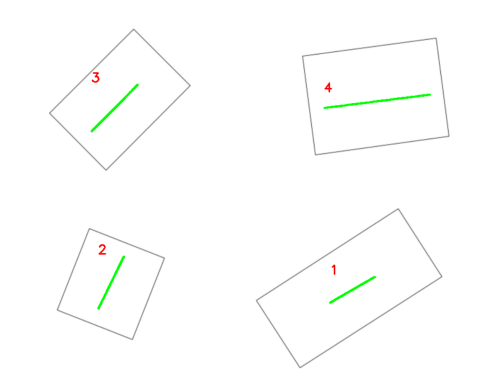

In [ ]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours with hierarchy
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_image = image.copy()
inner_lines = []

for i, cnt in enumerate(contours):
    if cv2.contourArea(cnt) < 50:
        continue

    parent = hierarchy[0][i][3]
    if parent != -1:  # inside something
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Skip big shapes (rectangle borders)
        px, py, pw, ph = cv2.boundingRect(contours[parent])
        if w > pw * 0.9 and h > ph * 0.9:
            continue

        # Consider as a line (no strict aspect ratio check so all angles work)
        length = cv2.arcLength(cnt, True)
        inner_lines.append((length, cnt, (x, y)))

# Sort globally by length (shorter first)
inner_lines.sort(key=lambda x: x[0])

# Draw and number
for num, (length, cnt, (x, y)) in enumerate(inner_lines, start=1):
    cv2.drawContours(contour_image, [cnt], -1, (0, 255, 0), 2)
    cv2.putText(contour_image, str(num), (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
